In [32]:
# !pip install dtreeviz

In [22]:
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
import pandas as pd
import numpy as np
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG
from sklearn.metrics import accuracy_score, recall_score, classification_report, confusion_matrix, make_scorer, adjusted_rand_score, silhouette_score, homogeneity_score, normalized_mutual_info_score


pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

# Tabular Data Approach

First load the same lsa data from the prior bag of words experimentation.

In [136]:
X_train = pd.read_csv('title_lsa_X_train.csv', low_memory=False).drop(['Unnamed: 0'], 1)
X_validation = pd.read_csv('title_lsa_X_test.csv', low_memory=False).drop(['Unnamed: 0'], 1)
y_train = pd.read_csv('title_lsa_y_train.csv', low_memory=False).drop(['Unnamed: 0'], 1)
y_validation = pd.read_csv('title_lsa_y_test.csv', low_memory=False).drop(['Unnamed: 0'],1)
train = pd.read_csv('title_lsa_train.csv', low_memory=False).drop(['Unnamed: 0'],1)
test = pd.read_csv('title_lsa_test.csv', low_memory=False).drop(['Unnamed: 0'],1)

# FastAI REALLY wants to do the train/validation splitting itself, so I have to re-merge the train and test...
df = pd.concat([train, test], ignore_index=True)

In [137]:
# print(f"X_train's shape: {X_train.shape}\nX_test's shape {X_validation.shape}\ny_train's shape {y_train.shape}\ny_test's shape {y_validation.shape}")

# print(train.shape, test.shape)
print(df.shape)

(5871, 921)


In [138]:
# prepare the sklearn metrics normed mutual info score
tst_reg = skm_to_fastai(normalized_mutual_info_score, is_class=True)

In [139]:
df.head(3)

,0,1,2,3,...,917,918,919,controversial
0,0.181259,-0.042566,-0.031585,-0.227923,...,0.000285,0.000577,0.001767,False
1,0.180734,-0.107807,-0.156737,0.084364,...,-0.007645,0.003584,0.022836,False
2,0.066126,0.320079,-0.130682,0.134803,...,-0.003189,-0.024748,-0.001777,True


In [140]:
splits = RandomSplitter(valid_pct=0.2)(range_of(df))  # can split randomly, no need to manage a time series

In [141]:
procs = []

In [142]:
dep_var='controversial'

In [143]:
cont,cat = cont_cat_split(df, 1, dep_var=dep_var)
print(len(cont), len(cat))

920 0


In [144]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

In [145]:
len(to.train),len(to.valid)

(4697, 1174)

In [146]:
to.show(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,controversial
3430,0.051527,0.010397,-0.002358,-0.000474,0.014012,-0.037034,-0.029749,-0.018812,-0.012091,-0.060239,-0.034485,-0.053181,-0.035587,0.004133,-0.022124,0.025984,0.002981,0.014357,0.068227,-0.022247,0.005345,0.025819,-0.035290,0.010568,-0.053784,0.022707,0.011584,0.000219,-0.009461,0.014373,0.011974,0.036895,-0.003884,-0.022248,0.081359,0.011552,-0.020587,0.017197,0.011574,-0.040208,0.026104,-0.014154,-0.000679,-0

In [147]:
import pickle
# file_pi = open('to.pkl', 'wb') 
# pickle.dump(to, file_pi)

file_pi = open('to.pkl','rb')
to = pickle.load(file_pi)

In [148]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [149]:
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y)

DecisionTreeRegressor(max_leaf_nodes=4)

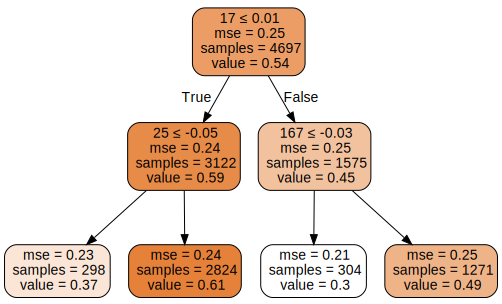

In [150]:
draw_tree(m, X_train, size=7, leaves_parallel=True, precision=2)

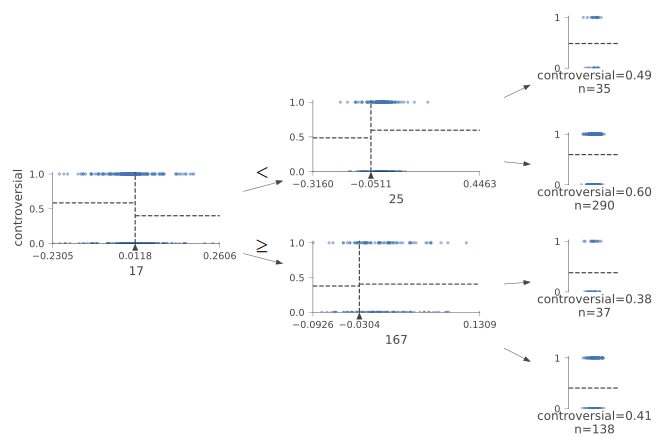

In [151]:
samp_idx = np.random.permutation(len(y))[:500]
dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

In [152]:
m = DecisionTreeRegressor()
m.fit(xs, y);

In [153]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [154]:
m_rmse(m, xs, y)

0.035492

In [155]:
m_rmse(m, valid_xs, valid_y)

0.570289

It's overfitting very very badly!

In [156]:
m.get_n_leaves(), len(xs)

(416, 4697)

The prior methods used accuracy, not r_mse, so let's re-run those measurements w accuracy.

In [157]:
def m_acc(m, xs, y): 
    y_pred = np.round(m.predict(xs),0)
    df = pd.DataFrame()
    df['y'] = y
    df['y_pred'] = y_pred
    correct = df.loc[df['y']==df['y_pred']]
    return ((correct.shape[0])/df.shape[0])

In [158]:
m_acc(m, xs, y)  # Only 99% accurate on the training set! No big deal...

0.9978709814775388

In [159]:
m_acc(m, valid_xs, valid_y)   # and 65% on validation. Not so bad

0.6746166950596252

In [160]:
def m_nmi(m, xs, y):
    y_pred = m.predict(xs)
    df = pd.DataFrame()
    nmi = normalized_mutual_info_score(y, y_pred)
    print(nmi)

In [161]:
validation_nmi = m_nmi(m, valid_xs, valid_y)
train_nmi = m_nmi(m, xs, y)

0.08991235303477434
0.9707279684798169


Number of leaves is ok. So that's not why. But it's not doing great anyways, no better than the prior methods. Let's try a random forest using this FastAI method. We already tried this in the prior work but hey let's do that anyway. The code is available!

In [162]:
def rf(xs, y, n_estimators=40, max_samples=4697,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [163]:
m = rf(xs, y)

In [164]:
m

RandomForestRegressor(max_features=0.5, max_samples=4697, min_samples_leaf=5,
                      n_estimators=40, n_jobs=-1, oob_score=True)

In [165]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)  # rmse

(0.235641, 0.435688)

In [166]:
m_acc(m, xs, y), m_acc(m, valid_xs, valid_y)  # 71% is a new high!

(0.9970193740685543, 0.7078364565587735)

In [167]:
m_nmi(m, valid_xs, valid_y)
m_nmi(m, xs, y)

0.17879377591497203
0.15352721082088322


In [58]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [59]:
r_mse(preds.mean(0), valid_y)

0.435373

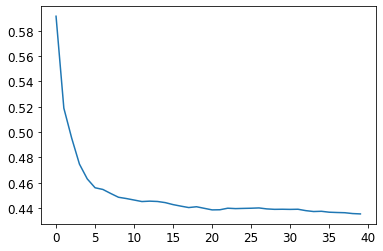

In [60]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(40)]);

In [61]:
r_mse(m.oob_prediction_, y)

0.444491

In [62]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [63]:
preds.shape

(40, 1174)

In [64]:
preds_std = preds.std(0)
preds_std[:5]

array([0.22629475, 0.44440201, 0.3046028 , 0.39824212, 0.44708058])

This is confidence.  Lower stdv means trees agree. Higher means they don't.

In [65]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [66]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
17,17,0.013576
22,22,0.007990
23,23,0.007589
25,25,0.007234
18,18,0.006910
6,6,0.005203
34,34,0.005169
11,11,0.005066
94,94,0.004425
244,244,0.003627


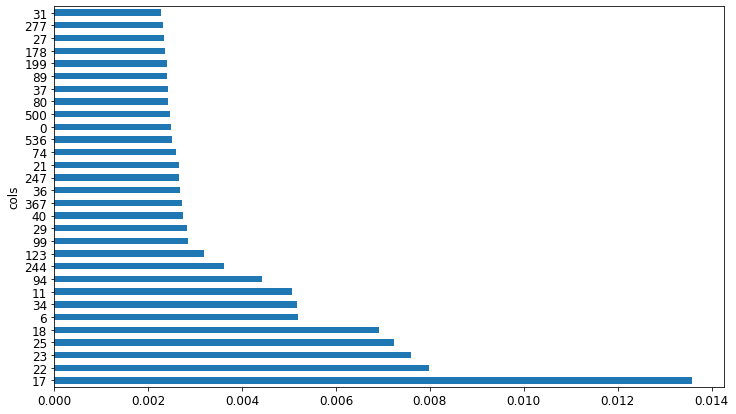

In [67]:


def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);



Unfortunately, I'm not sure how to actually see what 17 is referring to, as this is a value resulting from a dimensionality reduction using a TruncatedSVD. Which is a shame, as there are certainly some values that indicate a high likelihood of controversy.

In [68]:
fi.mean()

cols         inf
imp     0.001087
dtype: float64

In [69]:
fi.min()

cols              0
imp     4.74559e-05
dtype: object

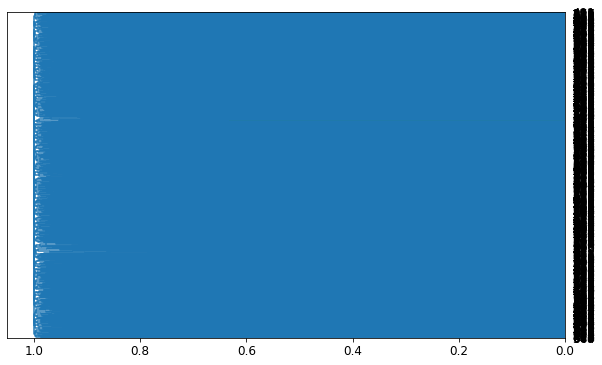

In [70]:
cluster_columns(xs)

 Clearly this chart is not useful with 920 columns.

# NN Tabular approach

In [79]:
train = pd.read_csv('title_lsa_train.csv', low_memory=False).drop(['Unnamed: 0'],1)
test = pd.read_csv('title_lsa_test.csv', low_memory=False).drop(['Unnamed: 0'],1)

# FastAI REALLY wants to do the train/validation splitting itself, so I have to re-merge the train and test...
df_nn_final = pd.concat([train, test], ignore_index=True)

In [80]:
splits = RandomSplitter(valid_pct=0.2)(range_of(df_nn_final))

In [81]:
dep_var = "controversial"

In [82]:
cont_nn,cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=dep_var)
len(cont_nn), len(cat_nn)

(920, 0)

In [83]:
# cont_nn = [int(value) for value in cont_nn]

In [84]:
procs_nn = []
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names='controversial')

In [85]:
dls = to_nn.dataloaders(1024)

In [86]:
dls.show_batch()

In [87]:
y = to_nn.train.y
y.min(),y.max()

(0, 1)

In [88]:
from fastai.tabular.all import *

In [99]:
learn = tabular_learner(dls, metrics=[accuracy, tst_reg])

In [90]:
import os
os.environ['CUDA_LAUNCH_BLOCKING']="1"

SuggestedLRs(lr_min=0.025118863582611083, lr_steep=0.005248074419796467)

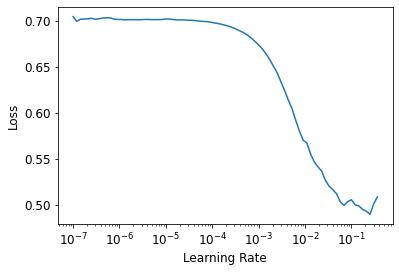

In [100]:
learn.lr_find()

In [101]:
learn.fit_one_cycle(20, 1e-2)  # find the steepest slope

epoch,train_loss,valid_loss,accuracy,normalized_mutual_info_score,time
0,0.691341,0.691809,0.543441,0.000000,00:00
1,0.631347,0.688843,0.552811,0.012562,00:00
2,0.543383,0.670766,0.661840,0.074405,00:00
3,0.467064,0.664614,0.551959,0.018206,00:00
4,0.399442,0.685854,0.500000,0.033309,00:00
5,0.344132,0.704265,0.543441,0.000000,00:00
6,0.292614,0.669407,0.576661,0.021484,00:00
7,0.249594,0.678660,0.580068,0.018723,00:00
8,0.216799,0.836148,0.492334,0.021898,00:00
9,0.190591,0.707486,0.615843,0.053760,00:00


Clearly overfitting on the training set after only the first couple epochs. Training acc achieved a peak of 71%, which is  the same as the last attempt.

In [93]:
preds,targs = learn.get_preds()
r_mse(preds,targs)

0.6783

In [97]:
print(preds.shape, targs.shape)

torch.Size([1174, 2]) torch.Size([1174, 1])


# NLP Approach

Using code from the FastAI textbook at https://github.com/fastai/fastbook/blob/master/10_nlp.ipynb

In [102]:
# from IPython.display import display,HTML
# from fastai import *
from fastai.text.all import *
import pandas as pd

### Preprocessing

In [103]:
# First, load the original text dataset.
# df = pd.read_csv('top_and_controversial_lg.csv', index_col=0)
df = pd.read_csv('top_and_controversial_lg_1.csv', index_col=0).drop(['Unnamed: 0.1', 'Unnamed: 0.1.1', "Unnamed: 0.1.1.1"],1)

To make sure we have the same split of data as in the previous work, I have to add an is_valid column to the data, but have to first use sklearn's train_test_split to split it into separate dataframes, and reassemble. It's tedious, but the price I pay for not being smarter about saving these.

In [104]:
y = df['controversial']

# drop all columns except the word counts
X = df.drop(['controversial'],1)

In [105]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   test_size = 0.2, 
                                                   random_state = 42,
                                                   stratify=y)
X_train.to_csv('X_train.csv')
X_test.to_csv('X_test.csv')
y_train.to_csv('y_train.csv')
y_test.to_csv('y_test.csv')

In [106]:
X_train = pd.read_csv('X_train.csv', index_col=0)
X_test=  pd.read_csv('X_test.csv', index_col=0)
y_train = pd.read_csv('y_train.csv', index_col=0)
y_test= pd.read_csv('y_test.csv', index_col=0)

In [107]:
X_train['controversial'] = y_train
X_train['is_valid'] = False
X_test['controversial'] = y_test
X_test['is_valid'] = True

In [108]:
df2 = pd.concat([X_train, X_test])

In [109]:
df2.columns

Index(['title', 'score', 'upvote_ratio', 'id', 'url', 'comms_num', 'created',
       'timestamp', 'char_count', 'word_count', 'char_count_quantile',
       'word_count_quantile', 'publisher', 'soup', 'p', 'titles_match',
       'sentiment', 'controversial', 'is_valid'],
      dtype='object')

In [111]:
# df2.to_csv('top_and_controversial_lg_2.csv')

In [110]:
df2 = pd.read_csv('top_and_controversial_lg_2.csv', index_col=0)

In [112]:
df2.head()

,title,score,upvote_ratio,id,...,titles_match,sentiment,controversial,is_valid
4096,"Car drives through dueling demonstrations between Black Lives Matter protesters, counter-protesters in Yorba Linda",107,0.81,j0k1er,...,False,POSITIVE,False,False
4559,Dallas Police Chief Resigns in Wake of Policing Protests,478,0.95,iq3nbw,...,True,NEGATIVE,False,False
2049,NYC restaurants can soon add a Covid-19 surcharge to customers' bills,823,0.92,ivtlx9,...,True,POSITIVE,True,False
4143,Judge orders Eric Trump to testify before election in New York attorney general probe of President Trump's company,59990,0.89,iygion,...,True,NEGATIVE,False,False
3568,"Whistleblower claims Mormon Church stockpiled $100 billion in charitable donations, dodged taxes",72072,0.93,ebqsxw,...,False,NEGATIVE,False,False


Now with that handled On to the main course, training this puppy.

In [113]:
# first the language model
lm = DataBlock(blocks=TextBlock.from_df('title', is_lm=True),
                    get_x=ColReader('text'),
                    splitter=ColSplitter())

In [114]:
dls = lm.dataloaders(df2, bs=64, seq_len=72, valid_col='is_valid')
dls.show_batch(max_n=6)

/home/sheba/anaconda3/envs/nlp/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,text,text_
0,"xxbos xxmaj mexico asks xxup u.s . to investigate use of tear gas at border xxbos xxmaj woman suspected of sending ricin - filled envelope to xxmaj white xxmaj house to appear in court xxbos xxmaj texas woman xxunk burned after hand sanitizer catches fire : "" my whole body was just xxunk in flames "" xxbos xxmaj california wildfire damage spotted from space ( photos ) xxbos xxup xxunk game is","xxmaj mexico asks xxup u.s . to investigate use of tear gas at border xxbos xxmaj woman suspected of sending ricin - filled envelope to xxmaj white xxmaj house to appear in court xxbos xxmaj texas woman xxunk burned after hand sanitizer catches fire : "" my whole body was just xxunk in flames "" xxbos xxmaj california wildfire damage spotted from space ( photos ) xxbos xxup xxunk game is delayed"
1,xxmaj how to xxmaj prepare for xxmaj covid-19 xxmaj vaccine by xxmaj early xxmaj november xxbos xxmaj search to resume for mass graves of xxmaj tulsa massacre victims xxbos xxmaj jon xxmaj xxunk : xxmaj officer involved in xxmaj breonna xxmaj taylor shooting sends xxunk email to xxup lmpd xxunk xxbos xxmaj jerry xxmaj falwell xxmaj jr . xxmaj resigns as xxmaj leader of xxmaj liberty xxmaj university xxbos xxmaj some xxmaj,how to xxmaj prepare for xxmaj covid-19 xxmaj vaccine by xxmaj early xxmaj november xxbos xxmaj search to resume for mass graves of xxmaj tulsa massacre victims xxbos xxmaj jon xxmaj xxunk : xxmaj officer involved in xxmaj breonna xxmaj taylor shooting sends xxunk email to xxup lmpd xxunk xxbos xxmaj jerry xxmaj falwell xxmaj jr . xxmaj resigns as xxmaj leader of xxmaj liberty xxmaj university xxbos xxmaj some xxmaj protests
2,bank in chokehold xxunk to one that killed xxmaj george xxmaj floyd . xxbos xxmaj missing xxunk - old and xxunk - old xxunk found alive xxbos xxmaj jury xxunk xxunk xxunk teen in girl 's xxunk death xxbos xxmaj xxunk mccann suspect may go free xxbos ' everything is a target ' : xxmaj gaza residents xxunk xxmaj israeli strikes xxbos xxmaj xxunk football player charged with assault after xxunk xxunk,in chokehold xxunk to one that killed xxmaj george xxmaj floyd . xxbos xxmaj missing xxunk - old and xxunk - old xxunk found alive xxbos xxmaj jury xxunk xxunk xxunk teen in girl 's xxunk death xxbos xxmaj xxunk mccann suspect may go free xxbos ' everything is a target ' : xxmaj gaza residents xxunk xxmaj israeli strikes xxbos xxmaj xxunk football player charged with assault after xxunk xxunk xxbos
3,"tarrant wanted to kill ' as many as possible ' xxbos xxup nasa worker sentenced for xxunk a minor xxbos xxup us weekly jobless claims hit xxunk million , xxunk 30 million over the last 6 weeks xxbos xxmaj white xxmaj house says it is creating ' very large ' xxunk on xxmaj washington xxmaj post journalist and others xxbos xxmaj sources : xxmaj fox xxmaj news xxmaj has xxmaj decided xxmaj","wanted to kill ' as many as possible ' xxbos xxup nasa worker sentenced for xxunk a minor xxbos xxup us weekly jobless claims hit xxunk million , xxunk 30 million over the last 6 weeks xxbos xxmaj white xxmaj house says it is creating ' very large ' xxunk on xxmaj washington xxmaj post journalist and others xxbos xxmaj sources : xxmaj fox xxmaj news xxmaj has xxmaj decided xxmaj bill"
4,"xxunk : report xxbos xxmaj if you made a claim for $ 125 from xxmaj xxunk , you ’re not getting it after court awards nearly $ 80 million to attorneys xxbos xxmaj new xxup us rules make it xxunk for asylum seekers to work xxbos xxup nfl xxmaj tickets xxmaj fall to an xxmaj xxunk $ 4 xxmaj xxunk xxbos xxup u.s . wants help finding parents deported without their children",": report xxbos xxmaj if you made a claim for $ 125 from xxmaj xxunk , you ’re not getting it after court awards nearly $ 80 million to attorneys xxbos xxmaj new xxup us rules make it xxunk for asylum seekers to work xxbos xxup nfl xxmaj tickets xxmaj fall to an xxmaj xxunk $ 4 xxmaj xxunk xxbos xxup u.s . wants help finding parents deported without their childre

In [115]:
for idx, inputs in enumerate(dls.valid):
    print(idx, inputs)

0 (LMTensorText([[   2,    8, 4034,  ...,   84,    8,   55],
        [ 108,   12,    0,  ...,  164,    2,    8],
        [  65,   41, 3639,  ...,  143,  228, 1712],
        ...,
        [   8, 1178,    8,  ...,    8,  405,   71],
        [  59, 3313,   91,  ...,    9, 1217,  139],
        [  13,   19,    8,  ...,  790,  110,  457]], device='cuda:0'), tensor([[   8, 4034,    8,  ...,    8,   55,   10],
        [  12,    0,   14,  ...,    2,    8,   46],
        [  41, 3639,  141,  ...,  228, 1712,   51],
        ...,
        [1178,    8, 3522,  ...,  405,   71,    2],
        [3313,   91,   18,  ..., 1217,  139,   41],
        [  19,    8, 2236,  ...,  110,  457,   27]], device='cuda:0'))
1 (LMTensorText([[  10,    8,  235,  ...,  871,    8,  141],
        [  46, 2571,  529,  ...,    0,    2,    8],
        [  51,   45, 1454,  ...,  478,    8,  134],
        ...,
        [   2,    8,   93,  ...,    2,    8,    0],
        [  41, 2182,  136,  ...,    8, 3050,   10],
        [  27,    7, 

In [116]:
learn = language_model_learner(
    dls, AWD_LSTM, drop_mult=0.3, 
    metrics=[accuracy, Perplexity(), tst_reg]).to_fp16()

SuggestedLRs(lr_min=0.05248074531555176, lr_steep=0.10000000149011612)

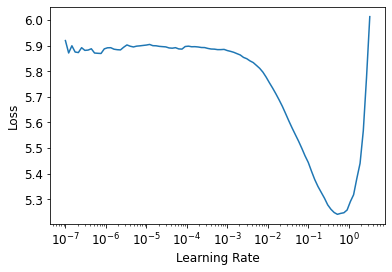

In [117]:
learn.lr_find()

In [118]:
learn.fit_one_cycle(1, 5e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,normalized_mutual_info_score,time
0,4.802166,4.138220,0.314583,62.691151,0.388571,00:04


So after only 1 epoch, it can predict the next work with 32% accuracy.

In [9]:
learn.save('1epoch-lm-2')

Path('models/1epoch-lm-2.pth')

In [10]:
learn = learn.load('1epoch-lm-2')

In [119]:
learn.unfreeze()
learn.fit_one_cycle(10, 2e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,normalized_mutual_info_score,time
0,3.797461,3.899237,0.345633,49.364754,0.403126,00:04
1,3.634547,3.832510,0.359430,46.178299,0.415932,00:04
2,3.453945,3.638824,0.377102,38.047058,0.437094,00:04
3,3.215166,3.603107,0.393849,36.712120,0.478044,00:04
4,2.941983,3.590591,0.409406,36.255493,0.515151,00:04
5,2.661795,3.555913,0.420195,35.019794,0.541776,00:04
6,2.404084,3.581158,0.432969,35.915096,0.555539,00:04
7,2.171967,3.594410,0.436436,36.394238,0.564437,00:04
8,1.994728,3.598141,0.438318,36.530251,0.562566,00:04
9,1.856583,3.604800,0.437118,36.774319,0.564730,00:04


43.5% correct prediciton of the next word ain't so shabby! But we aren't actually interested in prediction of the next word. We want prediction of whether or not it is controversial.

In [12]:
learn.save_encoder('finetuned-lm-2')

In [120]:
title_class = DataBlock(blocks=(TextBlock.from_df('title', seq_len=72, vocab=dls.vocab), CategoryBlock),
                      get_x=ColReader('text'),
                      get_y=ColReader('controversial'),
                      splitter=ColSplitter())

In [121]:
dl_class = title_class.dataloaders(df2, bs=128, seq_len=72)

/home/sheba/anaconda3/envs/nlp/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [122]:
dl_class.show_batch(max_n=3)

,text,category
0,"xxbos xxmaj infant among 3 fatally shot in south xxmaj kansas xxmaj city home . "" xxunk who have guns are going to use those guns for bad things . xxmaj and until we come to grips with that and start taking the guns out of the hands of people who should n’t have them , we ’re going to continue to have this . xxmaj it ’s just that xxunk . """,True
1,"xxbos xxmaj xxunk , xxmaj xxunk xxmaj say xxmaj they xxmaj have xxmaj xxunk 9 / 11 xxmaj was a ' lie ' — xxmaj new xxmaj york - xxmaj the group xxmaj xxunk and xxmaj xxunk for 9 / 11 xxmaj xxunk say they have xxunk evidence that xxunk the official story of the xxmaj september 11 , 2001 terrorist attacks was "" a lie ” and “ a fraud . ”",True
2,"xxbos ' no xxmaj drone xxmaj war . ' xxmaj thousands xxunk in protest outside xxmaj xxunk - xxmaj xxunk in rainbow peace xxunk and xxunk under xxunk , thousands of protesters xxunk in the xxunk xxmaj saturday outside xxmaj xxunk xxmaj air xxmaj base to demand the facility end its alleged support of xxup u.s . drone operations . xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad",True


In [123]:
learn = text_classifier_learner(dl_class, AWD_LSTM, drop_mult=0.5, 
                                metrics=[accuracy, tst_reg]).to_fp16()

In [124]:
learn = learn.load_encoder('finetuned-lm-2')

In [125]:
learn.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,normalized_mutual_info_score,time
0,0.992131,0.642728,0.636596,0.051009,00:04


In [126]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,normalized_mutual_info_score,time
0,0.834790,0.638653,0.627234,0.045167,00:04


In [127]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,normalized_mutual_info_score,time
0,0.683024,0.607692,0.674043,0.088417,00:04


In [128]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,normalized_mutual_info_score,time
0,0.602591,0.598665,0.691064,0.105006,00:04
1,0.570263,0.589209,0.702128,0.117708,00:04
2,0.535378,0.587875,0.705532,0.121957,00:04
3,0.507068,0.582631,0.720000,0.141523,00:04
4,0.482997,0.583584,0.714894,0.133944,00:04


Even this approach caps at about 72%.

In [22]:
learn.save('final-classifier-2')

Path('models/final-classifier-2.pth')

In [23]:
learn.export('final-classifier-2.pkl')

The next step is to deploy this and use it! 

https://medium.com/datadriveninvestor/fastai-and-render-quick-and-easy-way-to-create-and-deploy-computer-vision-models-14fd3f903cfc